In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Config:
file_id =  None #'<add_you_coco_dataset_dive_link>'  #Eg. '1fdgdgssytsyusrtyshgg' ensure data to be zip
file_id_weigths = None #'<trained_weights any>' #Eg. '1fdgdgsgsjusysetg' : format: model_weights_00_100.pth
file_csv = None #<add csv drive id >
file_train_csv = None
file_test_csv = None

In [3]:
import gdown
import shutil
from pathlib import Path
Gdrive = False # IF you want to save data of images keep true
folder_path = '/content/drive/MyDrive/' if Gdrive else '/content/'

In [4]:
%%bash
cd /content
cd "$folder_path"  #goto location
git clone https://github.com/omer770/multimodel_effnet.git
cd multimodel_effnet
cd weights
wget -q https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth #default weights
cd /content/

Cloning into 'multimodel_effnet'...


In [ ]:
if file_id:
  zip_path = gdown.download(id=file_id)
  !unzip -q {zip_path} -d {folder_path+'multimodel_effnet/data'}
  file_id = None
if file_csv:
  csv_name = gdown.download(id=file_csv)
  shutil.move(csv_name, folder_path+'multimodel_effnet/data')
  file_train_csv = None
if file_train_csv:
  train_csv_name = gdown.download(id=file_train_csv)
  shutil.move(train_csv_name, folder_path+'multimodel_effnet/data')
  file_train_csv = None
if file_test_csv:
  test_csv_name = gdown.download(id=file_test_csv)
  shutil.move(test_csv_name, folder_path+'multimodel_effnet/data')
  file_test_csv = None
if file_id_weigths:
  weights_path = gdown.download(id=file_id_weigths)
  weights_Dir = Path('/content/drive/MyDrive/Colab_zip/GroundingDINO/weights')
  weights_Dir.mkdir(parents=True, exist_ok=True)
  shutil.move(weights_path, weights_Dir)

In [12]:
%pwd

'/content/multimodel_effnet'

In [15]:
%cd {folder_path+'multimodel_effnet'}

/content/multimodel_effnet


In [8]:
!pip install -r requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.6 MB/s eta 0:00:00


In [53]:
import os
import torch
import torchvision
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
from torchinfo import summary
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0,EfficientNet_B0_Weights

In [43]:
from multimodel_effnet.Efficientnet.model import multimodel_effnet_arc
from multimodel_effnet.Efficientnet.util.dataset import display_random_images,CustomImageDataset
from multimodel_effnet.Efficientnet.util.metrics_utils import cross_entropy_loss_embedded,accuracy_embedded
from multimodel_effnet.Efficientnet.util.train_utils import train
from multimodel_effnet.Efficientnet.util.utils import save_model
from multimodel_effnet.Efficientnet.util.visualize import plot_loss_curves

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#torch.set_default_device(device)
print("device: ",device)
base_path = Path(folder_path)
#csv_path = base_path/'multimodel_effnet'/'data'/ csv_name
train_csv_path = base_path/'multimodel_effnet'/'data'/ test_csv_name
test_csv_path = base_path/'multimodel_effnet'/'data'/ test_csv_name
image_directory = '/content/multimodel_effnet/data/Datasets2'
weights_Dir = Path('/content/drive/MyDrive/Colab_zip/multimodel_effnet/weights')
weights_Dir.mkdir(parents=True, exist_ok=True)
df = pd.read_csv(csv_path)
attribs_m = ['Roof Condition', 'Roof Material','Roof Style','Solar Panel', 'Tree Overhang', 'Swimming Pool']
item_2_label_lst = [
    {'Fair':0, 'Good':1, 'Poor':2,'Damaged':3},
    {'Metal':0, 'Poly':1, 'Shingle':2, 'Tile':3,'Ballasted':4,'Asphalt':5},
    {'Flat':0, 'Gabled':1, 'Hip':2, 'Mixed':3},
    {'No':0,'Yes':1},
    {'Low':0, 'Medium':1,'High':2, 'No':3},
    {'No':0, 'Yes':1,'Screened':2}]
label_2_item_lst = [
    {0: 'Fair', 1: 'Good', 2: 'Poor', 3:'Damaged'},
    {0: 'Metal', 1: 'Poly', 2: 'Shingle', 3: 'Tile', 4: 'Ballasted', 5:'Asphalt'},
    {0: 'Flat', 1: 'Gabled', 2: 'Hip', 3: 'Mixed'},
    {0: 'No', 1:'Yes'},
    {0: 'Low', 1: 'Medium', 2:'High', 3: 'No'},
    {0: 'No', 1: 'Yes', 2:'Screened'}]
#print(df.head())

device:  cpu


In [61]:
weights = EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
effnet = efficientnet_b0
model = multimodel_effnet_arc.effnet_multimodel(model_name='b1',effnet=effnet, weights =weights)
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.effnet.parameters():
    param.requires_grad = False

In [59]:
#model.compile()

In [46]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.CenterCrop(768),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.CenterCrop(768),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [49]:
train_data_custom = CustomImageDataset(annotations_file=train_csv_path,
                                      img_dir=image_directory,
                                      attribs=attribs_m,
                                      item_2_label_lst =item_2_label_lst,
                                      label_2_item_lst=label_2_item_lst,
                                      transform=train_transforms)
test_data_custom = CustomImageDataset(annotations_file=test_csv_path,
                                      img_dir=image_directory,
                                      attribs=attribs_m,
                                      item_2_label_lst =item_2_label_lst,
                                      label_2_item_lst=label_2_item_lst,
                                      transform=test_transforms)

In [ ]:
display_random_images(train_data_custom,n=5,classes = True)

In [51]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_data_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape},{img_custom.device} -> [batch_size, color_channels, height, width]")
print(f"Label of {attribs_m}: {train_data_custom.decode_labels_onehot(label_custom)}")

Image shape: torch.Size([3, 224, 224]),cpu -> [batch_size, color_channels, height, width]
Label of ['Roof Condition', 'Roof Material', 'Roof Style', 'Solar Panel', 'Tree Overhang', 'Swimming Pool']: ['Fair', 'Ballasted', 'Flat', 'No', 'Low', 'Yes']


In [54]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

train_dataloader = DataLoader(
      train_data_custom,
      batch_size=BATCH_SIZE,
      #shuffle=True,
      #num_workers=NUM_WORKERS,
      pin_memory=True,
      generator=torch.Generator(device=device)
  )
test_dataloader = DataLoader(
      test_data_custom,
      batch_size=BATCH_SIZE,
      #shuffle=False,
      #num_workers=NUM_WORKERS,
      pin_memory=True,
      generator=torch.Generator(device=device)
  )

In [63]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
effnet_multimodel (effnet_multimodel)                             [32, 3, 224, 224]    [32, 4]              --                   Partial
├─EfficientNet (effnet)                                           [32, 3, 224, 224]    [32, 1280]           --                   False
│    └─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    │    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   (928)                False
│    │    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112, 112]   (1,448)              False
│    │    └─Sequential (2)                                        [32, 16, 112, 112]   [32, 24, 56, 56]     (16,714)             False
│    │    └─Sequential (3)                       

In [64]:
result = train(model=model,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=cross_entropy_loss_embedded,
      acc_fn= accuracy_embedded,
      epochs=5,
      device=device)

100%|██████████| 5/5 [27:09<00:00, 325.81s/it]

Epoch: 5 | train_loss: 0.9996 | train_acc: 0.6209 | test_loss: 0.8318 | test_acc: 0.6868


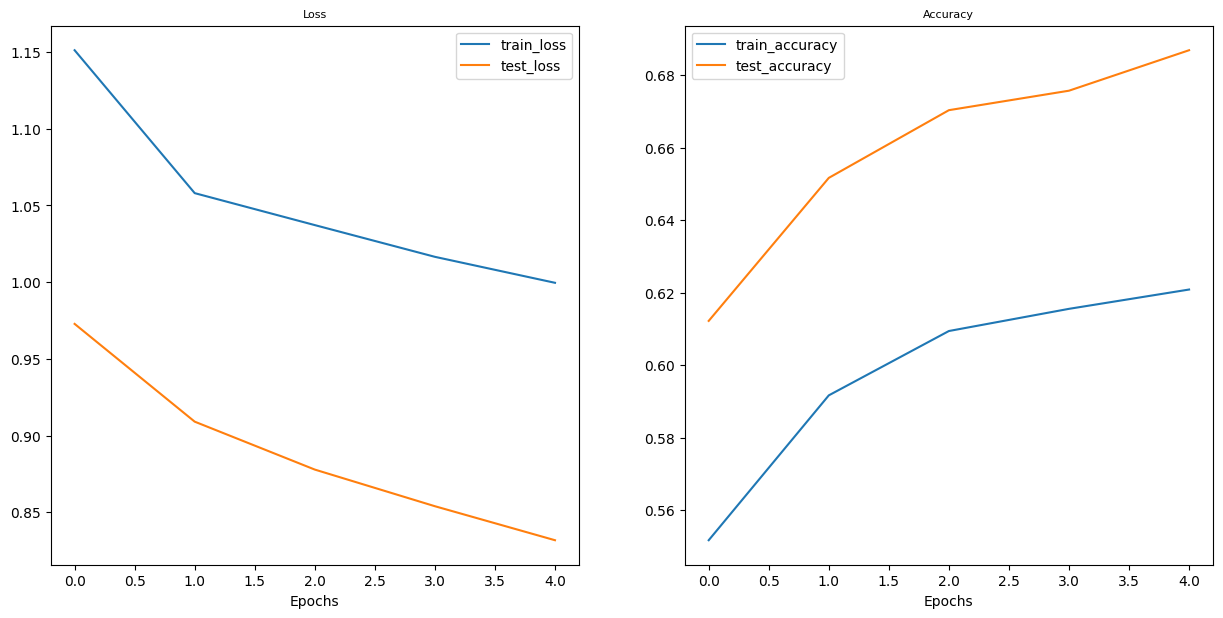

In [78]:
plot_loss_curves(result)

In [84]:
# Save a model to file
save_model(model= model,
           target_dir= weights_Dir,
           model_name= 'multimodel_effnet_temp.pth')

[INFO] Saving model to: /content/drive/MyDrive/Colab_zip/multimodel_effnet/weights/multimodel_effnet_temp.pth
